In [2]:
#libreria para manejo de NDARRAY
import numpy as np;
import scipy as sp
#libreria para graficar
import matplotlib.pyplot as plt
#Lector de archivos csv
from csv import reader as reader_csv;
import scipy.signal as signal;
import spacy
import scipy.io as sio
import scipy.stats as stats
from sympy import symbols
import os
import sympy as sym
import pandas as pd
from statsmodels.stats.diagnostic import lilliefors
from scipy.stats import mannwhitneyu
from scipy.stats import levene
import pingouin as pg
from scipy.signal import welch as pwelch

In [7]:
ruta_carpeta = '../control'

# Obtener la lista de archivos en la carpeta
lista_archivos = os.listdir(ruta_carpeta)

# Crear una matriz vacía para almacenar los datos
datos_matriz = [] # num_columnas es el número de columnas en los datos

# Iterar a través de cada archivo y agregar los datos a la matriz
for archivo in lista_archivos:
    # Verificar que el archivo sea de tipo .mat
    if archivo.endswith('.mat'):
        # Cargar los datos del archivo
        mat_contents = sio.loadmat(os.path.join(ruta_carpeta, archivo))
        data = mat_contents['data']
        senal_continua = np.reshape(data,(data.shape[0],data.shape[1]*data.shape[2]),order='F')
        # Agregar los datos a la matriz
        datos_matriz.append(data)

ruta_carpeta = '../parkinson'
lista_archivos = os.listdir(ruta_carpeta)
datos_parkinson=[]
for archivo in lista_archivos:
    # Verificar que el archivo sea de tipo .mat
    if archivo.endswith('.mat'):
        # Cargar los datos del archivo
        mat_contents = sio.loadmat(os.path.join(ruta_carpeta, archivo))
        data = mat_contents['data']
        senal_continua = np.reshape(data,(data.shape[0],data.shape[1]*data.shape[2]),order='F')
        # Agregar los datos a la matriz
        datos_parkinson.append(data)
print("Todo cargado")

Todo cargado


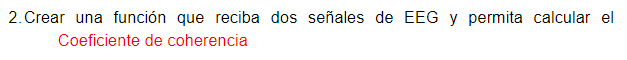

In [104]:
def coherence(data1,data2):
    X = np.fft.fft(data1)
    Y = np.fft.fft(data2)
    sxy = X * Y.conjugate()
    sxx = X * X.conjugate()
    syy = Y * Y.conjugate()
    return np.abs(np.mean(sxy.real))/np.sqrt(np.mean(sxx.real)*np.mean(syy.real))
#Nótese que en la ecuación cuando hablamos de la misma señal el n se torna como el numero de puntos así que se puede traducir en el promedio

In [107]:
coherence(datos_matriz[0][0][0],datos_matriz[0][0][0])

1.0

In [108]:
coherence(datos_matriz[0][1][0],datos_matriz[0][0][0])

0.7224334844699055

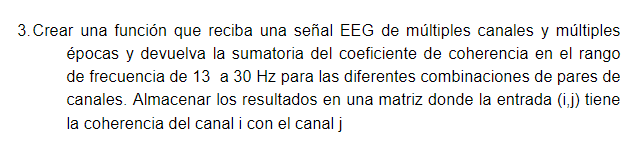

In [109]:
def coherence_matrix(data, fs):
    n_channels, n_samples ,n_epochs,  = data.shape
    
    # Definir los límites de frecuencia para calcular la coherencia
    fmin = 13
    fmax = 30
    
    # Calcular el índice de las frecuencias correspondientes
    freqs = np.fft.fftfreq(n_samples, 1/fs)
    idx_band = np.where((freqs >= fmin) & (freqs <= fmax))[0]
    
    # Inicializar la matriz de coherencia
    coh_matrix = np.zeros((n_channels, n_channels))
    
    # Calcular la coherencia para cada par de canales
    for i in range(n_channels):
        for j in range(n_channels):
            #Se inician vectores en 0 para cada par de operaciones ya que al ser el calculo en épocas y lo que nos interesa es una 
            #sumatoria de las frecuencias es más rápido por este medio
            sum_sxy= np.zeros(len(idx_band))
            sum_sxx= np.zeros(len(idx_band))
            sum_syy= np.zeros(len(idx_band))
            for k in range(n_epochs):
                #Se toman los puntos por cada época
                x = data[i, : , k]
                y = data[j, :, k]
                #Se saca la transformada en la epoca
                X = np.fft.fft(x)
                Y = np.fft.fft(y)
                #Se generan los vectores con el rango en especifico
                sxy = X[idx_band] * Y[idx_band].conjugate()
                sxx = X[idx_band] * X[idx_band].conjugate()
                syy = Y[idx_band] * Y[idx_band].conjugate()
                #Se suman los vectores a los anteriores para cumplir con la sumatoria a lo largo de las épocas 
                sum_sxy+=sxy.real
                sum_sxx+=sxx.real
                sum_syy+=syy.real
            #Con los vectores de sumatoria en la época se aplican las operaciones de la ecuación
            coh_sum=np.abs(sum_sxy/n_epochs)/np.sqrt(sum_sxx*sum_syy/(n_epochs**2))
            #Finalmente se suman los puntos de los vectores 
            coh_matrix[i, j] = np.sum(coh_sum) 
            
    return coh_matrix

In [101]:
a=coherence_matrix(datos_matriz[0],1000)

In [102]:
df=pd.DataFrame(a) 
df

,0,1,2,3,4,5,6,7
0,35.000000,27.158471,9.494119,6.862532,15.858306,2.677902,7.541589,11.835994
1,27.158471,35.000000,25.844251,7.023974,7.602380,8.530986,12.622465,14.833776
2,9.494119,25.844251,35.000000,22.915743,6.583487,13.226007,14.876855,14.194794
3,6.862532,7.023974,22.915743,35.000000,27.385674,14.519833,13.343328,9.591165
4,15.858306,7.602380,6.583487,27.385674,35.000000,12.373601,9.186112,4.268638
5,2.677902,8.530986,13.226007,14.519833,12.373601,35.000000,32.126576,19.497182
6,7.541589,12.622465,14.876855,13.343328,9.186112,32.126576,35.000000,27.554583
7,11.835994,14.833776,14.194794,9.591165,4.268638,19.497182,27.554583,35.000000


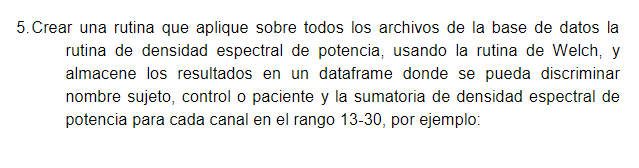

In [172]:
def PSD(data):
    fs=1000
    nperseg=2000
    noverlap=(nperseg//2)
    
    Tn=nperseg/fs
    fmin=int(13*Tn)
    fmax=int((30*Tn)+1)
   
    _,Pxx=pwelch(data,fs,"hamming",nperseg=nperseg,noverlap=noverlap)
    x=Pxx[fmin:fmax]
    
    return np.sum(x)


In [173]:
datosprompaciente=[]
r=np.arange(len(datos_matriz))
"""Se crea rutina con ciclos anidados para recorrer la matriz de pacientes y los canales de cada uno de estos"""

for i in r:
    promcanales=["Control"]
    x=datos_matriz[i]
    senal_continua = np.reshape(x,(x.shape[0],x.shape[1]*x.shape[2]),order='F')
    for canales in senal_continua:
        canal=PSD(canales)
        promcanales.append(canal)
    datosprompaciente.append(promcanales)

datosprompaciente_p=[]
r=np.arange(len(datos_parkinson))

for i in r:
    promcanales=["Parkinson"]
    x=datos_parkinson[i]
    senal_continua = np.reshape(x,(x.shape[0],x.shape[1]*x.shape[2]),order='F')
    for canales in senal_continua:
        canal=PSD(canales)
        promcanales.append(canal)
    datosprompaciente_p.append(promcanales)

In [174]:
names = ["Estado",'PSD_C3', 'PSD_C1', 'PSD_CZ', 'PSD_C2', 'PSD_C4', 'PSD_O1', 'PSD_OZ', 'PSD_O2'] #Los nombres de las columnas

In [175]:
df=pd.DataFrame(columns=names) #Se crea el data frame
con=1 
#Se inspecciona cada paciente, en este caso pandas toma las listas así que solo se coloca paciente 
# (lista con primedio de cada canal) y el contador para identificar el paciente
for paciente in datosprompaciente: 
    df.loc[con]=paciente
    con+=1
for paciente in datosprompaciente_p:
    df.loc[con]=paciente
    con+=1
df.index.name="Sujeto"
df

,Estado,PSD_C3,PSD_C1,PSD_CZ,PSD_C2,PSD_C4,PSD_O1,PSD_OZ,PSD_O2
Sujeto,,,,,,,,,
1,Control,9.062152,8.187032,8.209503,7.149991,7.953234,9.557815,7.621705,9.341435
2,Control,4.541114,4.474356,5.268274,5.377385,5.013520,14.985470,11.236807,12.328471
3,Control,4.525821,3.312598,5.547753,2.668167,5.553965,3.377261,3.464131,4.726387
4,Control,11.434981,8.564256,8.877882,8.869631,12.035870,18.066870,16.868238,18.372696
5,Control,7.792090,8.061644,8.008805,8.352176,8.866972,13.294795,9.861908,10.922841
6,Control,5.044943,4.180159,4.877620,4.267487,4.827144,5.678989,5.646178,6.722588
7,Control,4.117968,3.954962,4.620961,4.031215,4.445918,5.168547,4.037755,6.512078
8,Control,5.654712,3.725324,3.993182,3.987941,6.883226,8.159307,6.174555,7.206216
9,Control,1.857686,1.737646,2.003545,1.862828,2.005269,8.649002,8.559307,9.184750


In [176]:
df.to_csv("Tabla.cvs",index=False)

In [177]:
df=pd.read_csv("Tabla.cvs")

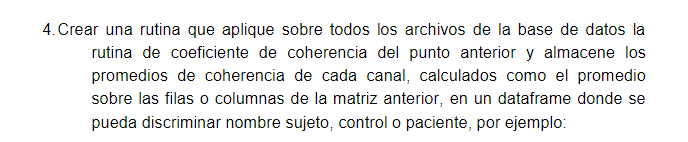

In [110]:
datosprompaciente=[]
r=np.arange(len(datos_matriz))
"""Se crea rutina con ciclos anidados para recorrer la matriz de pacientes y los canales de cada uno de estos"""

for i in r:
    promcanales="Control"
    x=coherence_matrix(datos_matriz[i],1000)
    x=x.mean(0).tolist()
    x.insert(0,promcanales)
    datosprompaciente.append(x)

datosprompaciente_p=[]
r=np.arange(len(datos_parkinson))

for i in r:
    promcanales="Parkinson"
    x=coherence_matrix(datos_matriz[i],1000)
    x=x.mean(0).tolist()
    x.insert(0,promcanales)
    datosprompaciente_p.append(x)

In [111]:
names = ["Estado",'Coherencia_promedio_PSD_C3', 'Coherencia_promedio_PSD_C1', 'Coherencia_promedio_PSD_CZ', 'Coherencia_promedio_PSD_C2', 'Coherencia_promedio_PSD_C4', 'Coherencia_promedio_PSD_O1', 'Coherencia_promedio_PSD_OZ', 'Coherencia_promedio_PSD_O2'] #Los nombres de las columnas

In [112]:
df=pd.DataFrame(columns=names) #Se crea el data frame
con=1 
#Se inspecciona cada paciente, en este caso pandas toma las listas así que solo se coloca paciente 
# (lista con primedio de cada canal) y el contador para identificar el paciente
for paciente in datosprompaciente: 
    df.loc[con]=paciente
    con+=1
for paciente in datosprompaciente_p:
    df.loc[con]=paciente
    con+=1
df.index.name="Sujeto"
df

,Estado,Coherencia_promedio_PSD_C3,Coherencia_promedio_PSD_C1,Coherencia_promedio_PSD_CZ,Coherencia_promedio_PSD_C2,Coherencia_promedio_PSD_C4,Coherencia_promedio_PSD_O1,Coherencia_promedio_PSD_OZ,Coherencia_promedio_PSD_O2
Sujeto,,,,,,,,,
1,Control,14.553614,17.327038,17.766907,17.080281,14.782275,17.244011,19.031439,17.097017
2,Control,16.743210,21.139847,22.638254,21.293390,17.487544,21.888139,23.616915,22.059106
3,Control,21.153811,22.975754,22.349906,21.748414,22.318046,19.205083,21.304379,20.427635
4,Control,15.679078,19.772166,20.245217,19.296772,14.577410,19.785985,21.256705,19.999231
5,Control,16.143768,19.872700,21.147171,18.944445,15.212077,19.603350,21.416090,19.344375
6,Control,14.132686,16.506231,17.572053,17.065609,14.457549,16.924206,18.300402,17.407010
7,Control,14.530466,20.760944,22.146609,21.168574,15.481755,22.244769,19.189866,21.113584
8,Control,14.666671,17.151017,17.405649,17.474087,14.595465,16.454309,18.803429,16.924583
9,Control,16.541623,22.309434,23.311713,22.051210,17.844247,20.983615,22.630786,21.020140


In [113]:
df.to_csv("Tabla_coherencia.cvs",index=False)

---

# Estadística descriptiva

Se leen las tablas anteriormente guardadas para evitar correr todas las rutinas cada vez

In [89]:
df=pd.read_csv("Tabla.cvs") #Datos de PSD
df2=pd.read_csv("Tabla.cvs") #Datos de coherencia

Se visualiza la diferencia entre los promedios

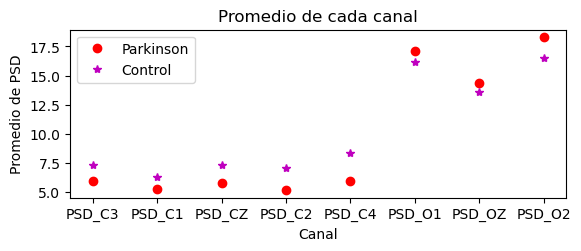

In [179]:
control,parkinson = [df[df['Estado']=='Control'], df[df['Estado']=='Parkinson']]
prom=[]
for i in control.columns[1:]:
    prom.append(control[i].mean())
promcontrol=pd.DataFrame(columns=control.columns[1:].to_list())
promcontrol.loc[0]=prom
prom=[]
for i in parkinson.columns[1:]:
    prom.append(parkinson[i].mean())
promparkinson=pd.DataFrame(columns=parkinson.columns[1:].to_list())
promparkinson.loc[0]=prom
plt.subplot(2,1,1)
plt.plot(promparkinson.loc[0], "or", linewidth='1',label="Parkinson" )
plt.plot(promcontrol.loc[0],"*m" , linewidth='1',label="Control" )
plt.title("Promedio de cada canal")
plt.ylabel("Promedio de PSD")
plt.xlabel("Canal")
plt.legend()

Se puede notar una diferencia entre los promedios de los pacientes parkinson y los pacientes control pero no se sabe si esta diferencia si es significativa

Se visualiza la distribución con histogramas

In [183]:
def grafhist(data):
    con=1
    names=data.columns
    plt.figure(figsize=(15,8))
    plt.suptitle("Distribución de datos de "+data[names[0]][0])
    for i in names[1:]:
        plt.subplot(2,4,con)
        plt.hist(data[i],bins=8)
        plt.axvline(data[i].mean(),color="r",linestyle="dashed",linewidth=2)
        plt.title(i)
        con+=1

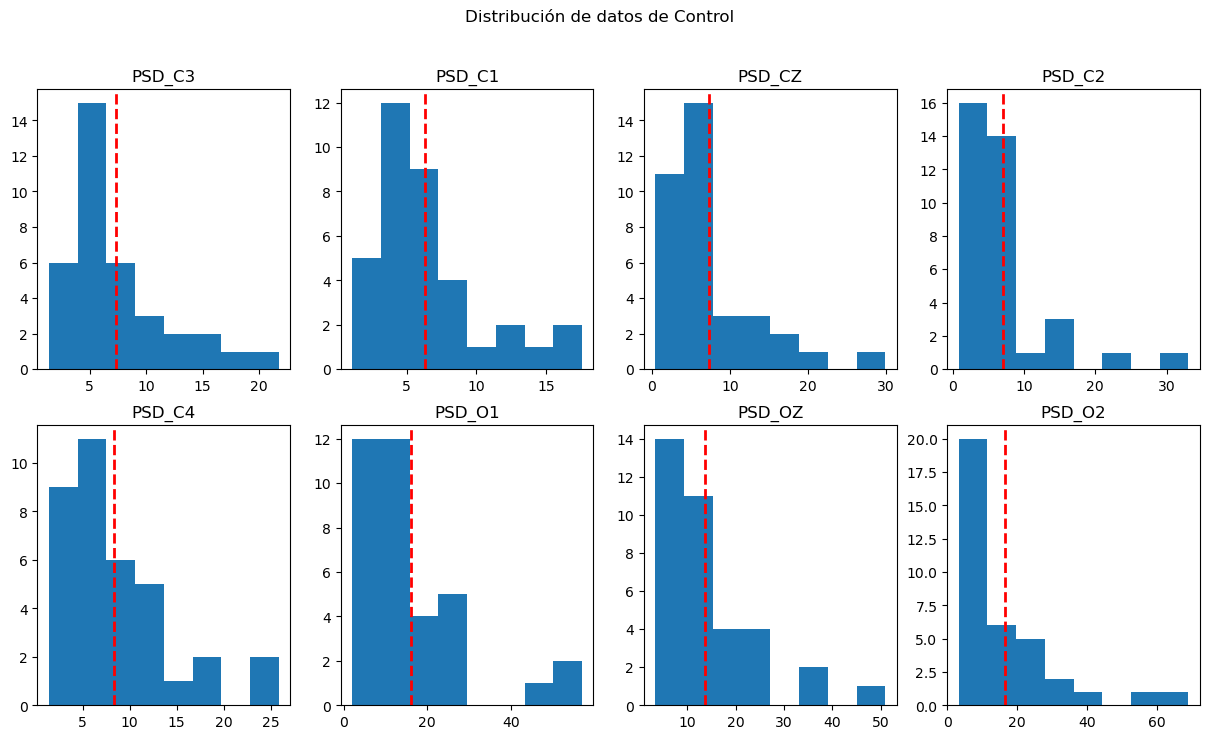

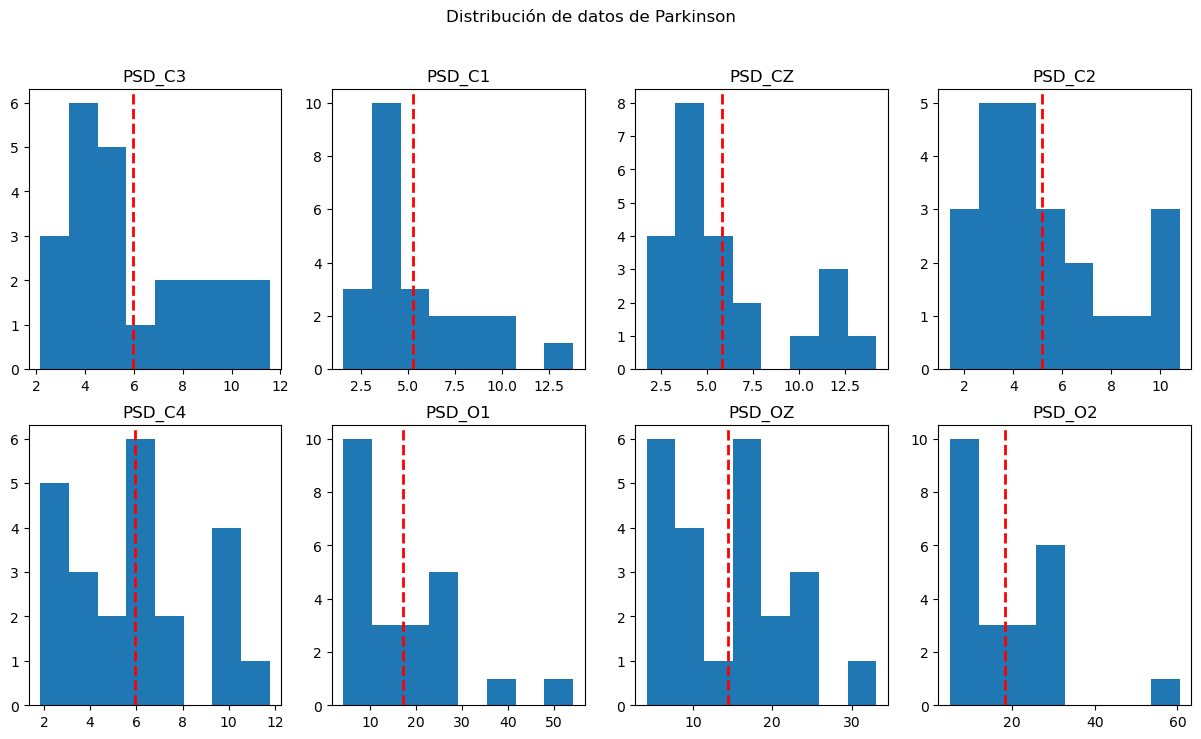

In [184]:
control,parkinson = [df[df['Estado']=='Control'], df[df['Estado']=='Parkinson']]
parkinson=parkinson.reset_index(drop=True)
names=control.columns
grafhist(control)
grafhist(parkinson)

Los datos no parecen seguir una distribución normal, requerida para realizar una prueba T

Se procede a visualizar mejor los datos con un diagrama de caja y bigotes el cual contiene la información de los gráficos anteriores y muestra la desviación

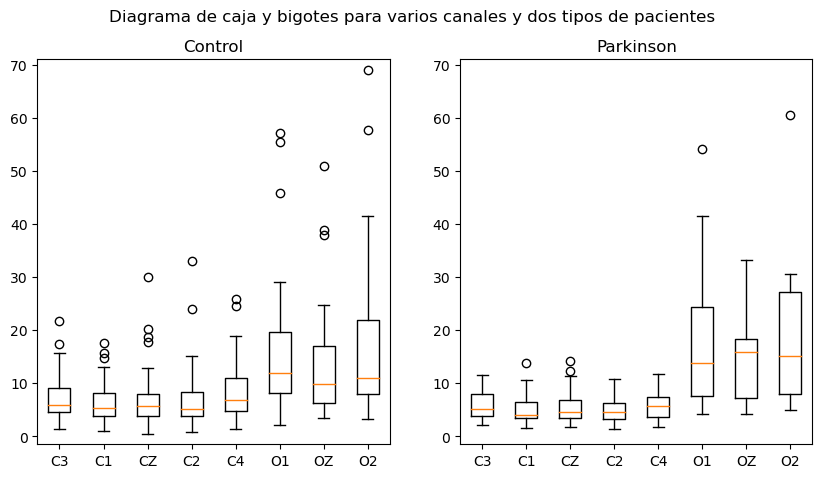

In [182]:
# Crear una lista de dataframes, uno por cada estado
dataframes = [df[df['Estado']=='Control'], df[df['Estado']=='Parkinson']]

# Crear una lista de nombres para las etiquetas del gráfico
labels = ['Control', 'Parkinson']
labels1=['C3', 'C1', 'CZ', 'C2', 'C4', 'O1', 'OZ', 'O2']
# Crear una figura y dos subplots (uno por cada estado)
fig, axs = plt.subplots(1, 2, figsize=(10,5))

# Para cada estado y subplot, hacer un diagrama de caja y bigotes para cada canal
for i, df_estado in enumerate(dataframes):
    axs[i].boxplot([df_estado['PSD_C3'], df_estado['PSD_C1'], df_estado['PSD_CZ'], df_estado['PSD_C2'], df_estado['PSD_C4'], df_estado['PSD_O1'], df_estado['PSD_OZ'], df_estado['PSD_O2']])
    axs[i].set_title(labels[i])
    axs[i].set_xticklabels(labels1)
    axs[i].set_ylim([-1.5, 71])
fig.suptitle('Diagrama de caja y bigotes para varios canales y dos tipos de pacientes')
plt.show()

---

# Estadistica inferencial

Se evalua normalidad con prueba de Shapiro-Wilk y Omnibus para ver si estos datos aplican para una prueba T.

In [185]:
def check_normality(data):

    pVals = pd.Series('p-value')
    # The scipy normaltest is based on D-Agostino and Pearsons test that
    # combines skew and kurtosis to produce an omnibus test of normality.
    _, pVals['Omnibus']    = stats.normaltest(data)

    # Shapiro-Wilk test
    _, pVals['Shapiro-Wilk']    = stats.shapiro(data)
    
    
    return [pVals['Shapiro-Wilk'],pVals['Omnibus']]

In [195]:
names=df.columns.values
normal={"Estado":"Control"}
pcontrol=sum(df["Estado"]=="Control")
for i in names[1:]: #Se aplica la prueba de normalidad a cada canal de los pacientes control
    
    c=df.loc[0:pcontrol-1,i]
    x,y=check_normality(c)
    if x>0.05 or y>0.05:
        normal[i]=[True]
    else:
        normal[i]=[False]
norm=pd.DataFrame.from_dict(normal)

In [ ]:
names=df.columns.values
normal={"Estado":"Parkinson"}
pcontrol=sum(df["Estado"]=="Control")
for i in names[1:]: #Se aplica la prueba de normalidad a cada canal de los pacientes parkinson

    c=df.loc[pcontrol:,i]
    x,y=check_normality(c)
    if x>0.05 or y>0.05:
        normal[i]=True
    else:
        normal[i]=False
norm=norm.append(normal,ignore_index=True)


In [197]:
norm

,Estado,PSD_C3,PSD_C1,PSD_CZ,PSD_C2,PSD_C4,PSD_O1,PSD_OZ,PSD_O2
0,Control,False,False,False,False,False,False,False,False
1,Parkinson,True,False,True,True,True,False,True,False


Para los pacientes control ningun canal sigue una distribución normal para la sumatoria del PSD para el rango de frecuencia entre 13 Hz y 30 Hz, mientras que para los pacientes Parkinson los canales C3, Cz, C2, C4 y Oz siguen una distribución normal.
Que algunos de los canales no sigan una distribución normal puede deberse a los datos tan atípicos que se encuentran en los canales de los pacientes control como en los canales que no tienen una distribución normal en los pacientes parkinson.

---

Debido a los resultados no es posible aplicar la Prueba T entre paciente control y parkinson para ningún canal. Por lo que se decide aplicar una prueba no paramétrica como la U de Mann Whitney aplicada para datos independientes, esta compara las medianas de las dos muestras y determina si son estadísticamente diferentes. La hipótesis nula de esta prueba es que no hay diferencia significativa entre las distribuciones de las dos muestras, por tanto la hipótesis alternativa será lo contrario, que hay diferencia significativas entre las distribuciones de las dos muestras.

In [202]:
stat, p = mannwhitneyu(control[names[1:9]],parkinson[names[1:9]])
con=0
for i in p: 
    print('Statistics=%.3f, p=%.3f for channel %s' % (stat[con], i,names[con+1]))
    con+=1
    #interpret
    alpha = 0.05
    if i > alpha:
        print('Same distribution (fail to reject H0)')
    else:
        print('Different distribution (reject H0)')

Statistics=486.000, p=0.266 for channel PSD_C3
Same distribution (fail to reject H0)
Statistics=476.000, p=0.339 for channel PSD_C1
Same distribution (fail to reject H0)
Statistics=479.000, p=0.316 for channel PSD_CZ
Same distribution (fail to reject H0)
Statistics=474.000, p=0.355 for channel PSD_C2
Same distribution (fail to reject H0)
Statistics=504.000, p=0.164 for channel PSD_C4
Same distribution (fail to reject H0)
Statistics=394.000, p=0.762 for channel PSD_O1
Same distribution (fail to reject H0)
Statistics=353.000, p=0.347 for channel PSD_OZ
Same distribution (fail to reject H0)
Statistics=364.000, p=0.442 for channel PSD_O2
Same distribution (fail to reject H0)


En este caso se falla al rechazar la hipótesis nula, lo que quiere decir que la probabilidad de que las dos muestras (aplica para cada par de canales control y parkinson) provengan de distribuciones significativamente diferentes es muy baja